# Diabetes prediction: random forest

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform, loguniform
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

import configuration as config
import functions as funcs

## 1. Data loading

### 1.1. Load data from disk

Load the pre-processed data from the decision tree notebook:

In [2]:
with open(config.DATA_FILE, 'rb') as input_file:
    dataset = pickle.load(input_file)

training_df = dataset['training']
testing_df = dataset['testing']

### 1.2. Inspect

In [3]:
training_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
752,3,108.0,62.0,24.000000,90.021526,26.0,0.223,25,0
637,2,94.0,76.0,18.000000,66.000000,31.6,0.649,23,0
585,1,93.0,56.0,11.000000,104.446503,22.5,0.417,22,0
765,5,121.0,72.0,23.000000,112.000000,26.2,0.245,30,0
29,5,117.0,92.0,28.518763,126.114944,34.1,0.337,38,0


## 2. Model training

In [4]:
cross_val_scores = {
    'Model': [],
    'Score': []
}

### 2.1. Baseline

Load and score the decision tree model from the first notebook:

In [5]:
with open(config.DECISION_TREE_MODEL, 'rb') as input_file:
    model = pickle.load(input_file)

scores = cross_val_score(
    model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Decision tree']*len(scores))
cross_val_scores['Score'].extend(scores * 100)

print(f'Decision tree cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Decision tree cross-validation accuracy: 71.4 +/- 5.1%


### 2.2. Random forest model

Score a random forest model:

In [6]:
scores = cross_val_score(
    RandomForestClassifier(class_weight='balanced'),
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Random forest']*len(scores))
cross_val_scores['Score'].extend(scores * 100)

print(f'Random forest cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Random forest cross-validation accuracy: 74.5 +/- 7.0%


## 3. Hyperparameter optimization

### 3.1. Hyperparameter grid search

In [7]:
hyperparameters = {
    'n_estimators': randint(2, 200),
    'criterion':['gini','entropy','log_loss'],
    'max_depth':randint(1, 20),
    'min_weight_fraction_leaf':loguniform(10**-5, 0.5),
    'max_features':uniform(loc=0.1, scale=0.9),
    'min_impurity_decrease':loguniform(10**-5, 1.0),
    'ccp_alpha':loguniform(10**-5, 1.0)
}

search = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced'),
    hyperparameters,
    return_train_score=True,
    cv=3,
    n_jobs=-1,
    n_iter=10000
)

search_results = search.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
best_model = search_results.best_estimator_
hyperparameters = search_results.best_params_

print('Best hyperparameters:\n')

for key, value in hyperparameters.items():
    print(f' {key}: {value}')

print()


Best hyperparameters:

 ccp_alpha: 0.0167653555393281
 criterion: entropy
 max_depth: 19
 max_features: 0.947429209936057
 min_impurity_decrease: 8.723527099994545e-05
 min_weight_fraction_leaf: 0.030982508759453745
 n_estimators: 136



### 3.2. Hyperparameter optimization results

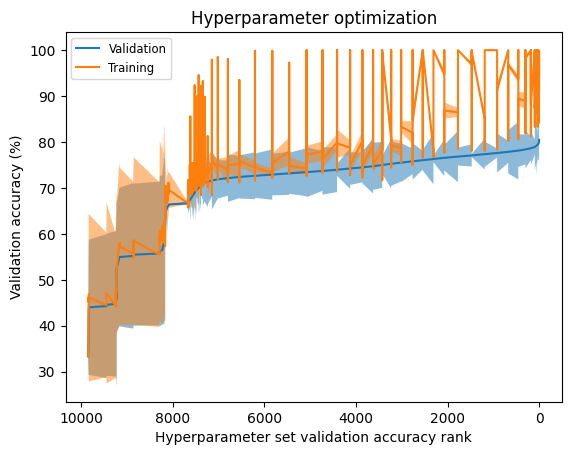

In [8]:
funcs.plot_cross_validation(search_results)

### 3.3. Cross-validation of optimized model

In [9]:
scores = cross_val_score(
    best_model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=7,
    n_jobs=-1
)

cross_val_scores['Model'].extend(['Optimized Random Forest']*len(scores))
cross_val_scores['Score'].extend(scores * 100)

print(f'Optimized random forest cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Optimized random forest cross-validation accuracy: 76.8 +/- 7.4%


## 4. Evaluation

### 4.1. Model comparison

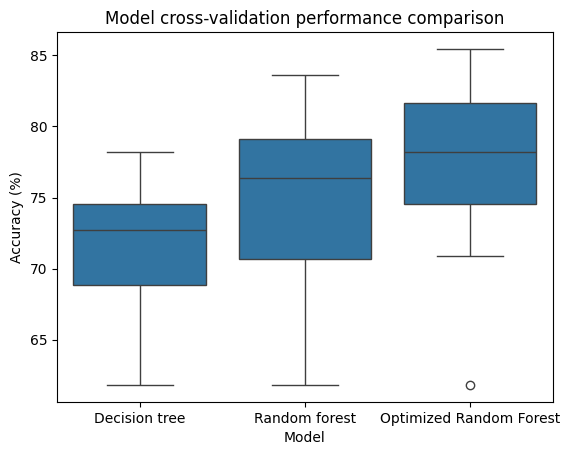

In [10]:
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Model cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.show()

### 4.2. Test set performance

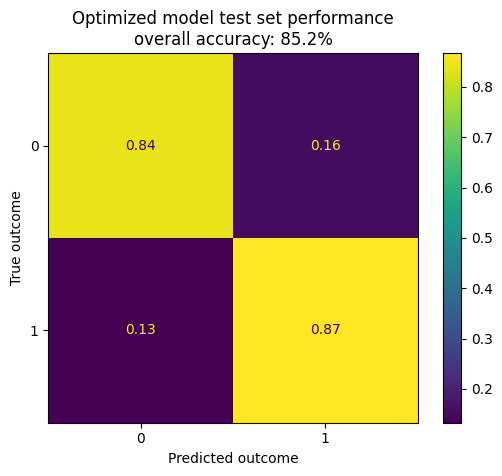

In [11]:
testing_predictions = best_model.predict(testing_df.drop('Outcome', axis=1))
accuracy = accuracy_score(testing_predictions, testing_df['Outcome']) * 100

# Plot the confusion matrix
cm = confusion_matrix(testing_df['Outcome'], testing_predictions, normalize='true')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
_= cm_disp.plot()

plt.title(f'Optimized model test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted outcome')
plt.ylabel('True outcome')
plt.show()

## 5. Save

### 5.1. Optimized hyperparameters

In [12]:
with open(config.RANDOM_FOREST_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(hyperparameters, output_file)

### 6.2. Model

In [13]:
with open(config.RANDOM_FOREST_MODEL, 'wb') as output_file:
    pickle.dump(model, output_file)